In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch 
import numpy as np 
import torch.nn as nn 
from transformers import GPT2TokenizerFast
from PIL import Image
import matplotlib.pyplot as plt

tokenizer = GPT2TokenizerFast.from_pretrained('ai-forever/rugpt3small_based_on_gpt2')

c:\code\anaconda3\envs\transaltion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torchvision.transforms as transforms 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
max_length=50
import os
class Dataset:
    def __init__(self, df, root_dir='1/flickr30k_images'):
        self.df = df
        self.tfms = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image_name']
        caption = sample['rus_cap']
        image = os.path.join(self.root_dir, image)
        image = Image.open(image).convert('RGB')
        augs = self.tfms(image)
        captions = tokenizer.encode(caption, max_length=max_length, padding="max_length", truncation=True)
        return augs, captions

In [5]:
train_df = pd.read_parquet('train.parquet')
val_df = pd.read_parquet('val.parquet')

In [6]:
train_ds = Dataset(train_df)
val_ds = Dataset(val_df)

In [7]:
from torch.utils.data import DataLoader

def collate_fn(data):
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    
    captions = [[tokenizer.bos_token_id] + cap + [tokenizer.eos_token_id] for cap in captions]

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths), dtype=torch.long)
    masks = torch.zeros(len(captions), max(lengths), dtype=torch.long)
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i] = torch.LongTensor(cap)
        masks[i,] = torch.tensor([1 if cap_part !=0 else 0 for cap_part in cap], dtype=torch.long)
    
    return images, targets, masks 

train_dataloader = DataLoader(train_ds, batch_size=8, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=8, collate_fn=collate_fn, shuffle=False)

In [8]:
next(iter(val_dataloader))[-1][1]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

Images batch shape :torch.Size([8, 3, 224, 224])
Captions batch shape :8
tensor(1)
tensor([    1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0, 41585,   282, 44432,
         2894,   845, 16776, 32336,   305,   281,  6631,   323,   282,  8259,
           18,     2])


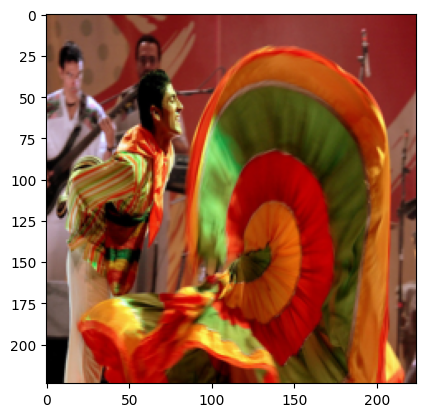

Label : <s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>Мужчина в испанской вечерней одежде танцует с дамой в платье.</s>


In [9]:
images, captions, attention_masks = next(iter(train_dataloader))

def tensor_to_image(tensor):
    # Convert the tensor to a PIL Image
    return transforms.ToPILImage()(tensor)

print(f"Images batch shape :{images.size()}")
print(f"Captions batch shape :{len(captions)}")
img = tensor_to_image(images[0])
print(torch.where(captions[0] == 0)[0][0])
caption = captions[0]
print(caption)
label = tokenizer.decode(caption, skip_special_token=True)
plt.imshow(img)
plt.show()
print(f"Label : {label}")

In [37]:
from transformers import GPT2LMHeadModel
from torchvision.models import resnet152

resnet = resnet152(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-2]) # Remove avg pool and fc layer 

gpt2 = GPT2LMHeadModel.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet.to(device)
gpt2.to(device)

c:\code\anaconda3\envs\transaltion\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\code\anaconda3\envs\transaltion\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [38]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, resnet, gpt2):
        super(ImageCaptioningModel, self).__init__()
        self.resnet = resnet 
        self.gpt2 = gpt2 

        self.proj = nn.Linear(2048, gpt2.config.hidden_size)
    
    def forward(self, images, input_ids, attention_mask=None):
        img_features = self.resnet(images)
        img_features = img_features.mean([2,3])
        img_features = self.proj(img_features)

        input_embeddings = self.gpt2.transformer.wte(input_ids)
        combined_embeddings =  input_embeddings + img_features.unsqueeze(1) 

        outputs = self.gpt2(inputs_embeds=combined_embeddings, attention_mask=attention_mask, labels=input_ids)
        return outputs 

In [39]:
from transformers import AdamW

model = ImageCaptioningModel(resnet, gpt2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
print_every = 500

In [40]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0 
    iteration_loss = 0 
    
    for idx, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        images, input_ids, masks = batch 
        
        optimizer.zero_grad()
        
        outputs = model(images, input_ids, attention_mask = masks)
        loss = outputs.loss
        
        loss.backward()
        
        optimizer.step()
        
        total_loss +=loss.item()
        iteration_loss += loss.item()
        
        if idx % print_every == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} | Iteration {idx}/{len(train_dataloader)} | "
                  f"Training Loss: {iteration_loss / print_every:.3f}")
            iteration_loss = 0
    
    model.eval()
    val_loss = 0 
    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            images, input_ids, masks = batch 
            outputs = model (images, input_ids, attention_mask=masks)
            loss = outputs.loss
            val_loss += loss.item()
    val_loss = val_loss / len(val_dataloader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {total_loss / len(train_dataloader):.3f} | "
          f"Validation Loss: {val_loss:.3f}\n")

Epoch 1/3 | Iteration 500/2195 | Training Loss: 2.542
Epoch 1/3 | Iteration 1000/2195 | Training Loss: 1.222
Epoch 1/3 | Iteration 1500/2195 | Training Loss: 1.063
Epoch 1/3 | Iteration 2000/2195 | Training Loss: 0.984
Epoch 1/3 | Training Loss: 1.409 | Validation Loss: 1.024

Epoch 2/3 | Iteration 500/2195 | Training Loss: 0.900
Epoch 2/3 | Iteration 1000/2195 | Training Loss: 0.891
Epoch 2/3 | Iteration 1500/2195 | Training Loss: 0.887
Epoch 2/3 | Iteration 2000/2195 | Training Loss: 0.891
Epoch 2/3 | Training Loss: 0.891 | Validation Loss: 1.075

Epoch 3/3 | Iteration 500/2195 | Training Loss: 0.801
Epoch 3/3 | Iteration 1000/2195 | Training Loss: 0.814
Epoch 3/3 | Iteration 1500/2195 | Training Loss: 0.818
Epoch 3/3 | Iteration 2000/2195 | Training Loss: 0.810
Epoch 3/3 | Training Loss: 0.811 | Validation Loss: 0.964



In [48]:
torch.save(model.state_dict(), 'resnet-gpt')

In [13]:

model.load_state_dict(torch.load('resnet-gpt', weights_only=True))

<All keys matched successfully>

In [24]:
model.eval()

ImageCaptioningModel(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [41]:
def generate_caption(image, model, tokenizer, max_length=50, temperature=1.0):
    
    caption = [tokenizer.bos_token_id]
    
    model.eval()
    
    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image.unsqueeze(0), input_ids)
            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)
            if predicted_id == tokenizer.eos_token_id and i>1:
                break
    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption 

In [42]:
tokenizer.eos_token_id

2

In [43]:
images

tensor([[[[0.9333, 0.9333, 0.9333,  ..., 0.9098, 0.9137, 0.9137],
          [0.9294, 0.9294, 0.9333,  ..., 0.9098, 0.9098, 0.9137],
          [0.9176, 0.9216, 0.9294,  ..., 0.9137, 0.9176, 0.9137],
          ...,
          [0.8510, 0.7529, 0.6314,  ..., 0.8588, 0.8706, 0.8784],
          [0.8980, 0.9059, 0.9137,  ..., 0.8784, 0.8824, 0.8902],
          [0.8980, 0.8980, 0.9059,  ..., 0.8824, 0.8784, 0.8824]],

         [[0.9176, 0.9176, 0.9176,  ..., 0.8863, 0.8863, 0.8941],
          [0.9176, 0.9137, 0.9176,  ..., 0.8980, 0.8941, 0.8980],
          [0.9137, 0.9137, 0.9137,  ..., 0.9020, 0.8980, 0.8980],
          ...,
          [0.8392, 0.7647, 0.6941,  ..., 0.8510, 0.8588, 0.8667],
          [0.8941, 0.8980, 0.9059,  ..., 0.8706, 0.8745, 0.8745],
          [0.8902, 0.8941, 0.9020,  ..., 0.8745, 0.8667, 0.8667]],

         [[0.9059, 0.9059, 0.9059,  ..., 0.8745, 0.8745, 0.8745],
          [0.9176, 0.9137, 0.9059,  ..., 0.8863, 0.8863, 0.8902],
          [0.9137, 0.9137, 0.9137,  ..., 0

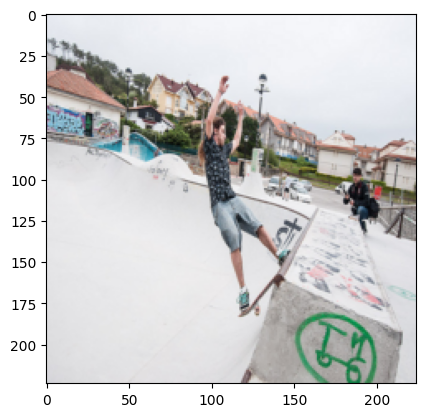

Label :  человек, катающийся на сноуборде, и


In [47]:
images, _, _ = next(iter(train_dataloader))
image = images[3].to(device)
img = tensor_to_image(image)

caption = generate_caption(image, model, tokenizer, temperature=1)

plt.imshow(img)
plt.show()
print(f"Label : {caption}")